In [1]:
%pylab nbagg
%matplotlib inline
from tvb.simulator.lab import *
import os.path
from matplotlib import colors, cm
import time
import scipy.signal as sig

import numpy as np
import pandas as pd
import scipy.io

# downloaded library for peak detection in z time series
import peakdetect
from runmainsim import *
import tvbsim

import re
import sys
sys.path.append('/Users/adam2392/Documents/fragility_analysis/')
import fragility.signalprocessing as sp

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
# patient = 'id002_cj'
patient = 'id001_ac'

# get the cortical surface meta data
metadatadir = os.path.join("/Users/adam2392/Documents/tvb/metadata/", patient)
cort_surf = surfaces.CorticalSurface.from_file(source_file=os.path.join(metadatadir, "surface_cort.zip"))
cort_surf.configure()
display(cort_surf.summary_info)

# read in seeg file
seeg = pd.read_csv(os.path.join(metadatadir, "seeg.txt"), names=['x', 'y', 'z'], delim_whitespace=True)
seeg_labels = seeg.index
seeg_xyz = seeg.as_matrix()

{'Edge lengths, longest (mm)': 11.32615848876635,
 'Edge lengths, mean (mm)': 1.0372261079362926,
 'Edge lengths, shortest (mm)': 0.018795094413170094,
 'Has two hemispheres': False,
 'Number of edges': 689340,
 'Number of triangles': 459560,
 'Number of vertices': 229784,
 'Surface type': 'CorticalSurface',
 'Valid for simulations': False}

In [3]:
eznum=0
pznum=0

# Set the directory and file to read
outputdir = os.path.join('/Users/adam2392/Documents/pydata/tvb_forwardsim/', patient)
if not os.path.exists(outputdir):
    os.mkdir(outputdir)
filename = os.path.join(outputdir, patient+'_sim_nez'+str(eznum)+\
                                '_npz'+str(pznum)+'.npz')
# load simulated data
data = np.load(filename)

# extract data and metadata from simulation
epits = data['epits']
zts = data['zts']
times = data['times']
seegts = data['seegts']

metadata = data['metadata'].item()
seeg_labels = metadata['seeg_contacts']
seeg_xyz = metadata['seeg_xyz']
region_labels = metadata['regions']
region_centers = metadata['regions_centers']
ezregions = metadata['ez']
pzregions = metadata['pz']
ezindices = metadata['ezindices']
onsettimes = metadata['onsettimes']
offsettimes = metadata['offsettimes']

print filename
# print findonsetoffset(zts[ezindices,:])
print data.keys()
print "Meta data contains: ", metadata.keys()
print "ez indices: ", metadata['ezindices']
print "ez region: ", ezregions
print "pz indices: ", metadata['pzindices']
print "pz region: ", pzregions

postprocessor = tvbsim.util.PostProcess(epits, seegts, times)
if eznum > 0:
    onsettimes, offsettimes = postprocessor.findonsetoffset(zts[ezindices, :].squeeze(), delta=0.2)
else:
    onsettimes = []
    offsettimes = []
    
# initialize object to assist in moving seeg contacts
movecontact = tvbsim.util.MoveContacts(seeg_labels, seeg_xyz, 
                                       region_labels, region_centers, True)
ezseegindex = []
for ezindex in ezindices:
    print "Moving onto current ez index: ", ezindex, " at ", regions[ezindex]
    # find the closest contact index and distance
    ezseegindex, distance = movecontact.findclosestcontact(ezindex)
    
    print ezseegindex, distance
    print seeg_labels[ezseegindex]
    
# initialize dsp object to perform dsp fitlering
# dspobject = sp.filters.SignalProcessing(seegts)
# seegts = dspobject.filterrawdata(freqrange=[59.5, 60.5], )

/Users/adam2392/Documents/pydata/tvb_forwardsim/id001_ac/id001_ac_sim_nez0_npz0.npz
['metadata', 'zts', 'seegts', 'epits', 'times']
Meta data contains:  ['patient', 'pz', 'onsettimes', 'seeg_xyz', 'x0ez', 'regions_centers', 'regions', 'seeg_contacts', 'offsettimes', 'x0pz', 'ez', 'pzindices', 'x0norm', 'ezindices']
ez indices:  []
ez region:  []
pz indices:  []
pz region:  []


In [4]:
elect = []
dipole = []

# create lists of elect and dipoles
for element in range(0,seeg.shape[0]):
    kpm = np.array(re.match("([A-Z]+[a-z]*[']*)([0-9]+)", seeg_labels[element]).groups())
    elect.append(kpm[0])
    dipole.append(int(kpm[1]))

'''
Descrip: 
- Number of electrodes is : len(find_0)
- Number of contacts per an electrode i is nbr_contacts[i+1]

''' 
# find the beginning index of each electrode
find_0 = []
nbr_contacts = []
for element_1 in range(0, len(dipole)):
    if dipole[element_1] == 1:
        find_0.append(element_1)
for element_2 in range(0, len(find_0)-1):
    nbr_contacts.append(find_0[element_2+1]-find_0[element_2])
nbr_contacts.append(len(seeg_labels)- find_0[len(find_0)-1])

# Find the list of the ending index of each electrode
incr_cont = np.zeros((len(nbr_contacts)), dtype=int)
incr_cont[0] = 0

for element_4 in range(0, len(nbr_contacts)):
    incr_cont[element_4] = incr_cont[element_4-1] + nbr_contacts[element_4]

    
print "Nbre_contacts_per_electrode:", nbr_contacts
print "Nbre_electrodes:", len(nbr_contacts)
print "Ending Index of electrodes:", incr_cont # To plot each electrode with diff color

print sum(nbr_contacts) # to be sure that the code is correct
print len(seeg_labels)

Nbre_contacts_per_electrode: [14, 14, 9, 2, 4, 9, 9, 9]
Nbre_electrodes: 8
Ending Index of electrodes: [14 28 37 39 43 52 61 70]
70
70


ezreion is:  []
pzregion is:  []
x0 values are (ez, pz, norm):  -1.6 -2.04 -2.5
time series shape is:  (84, 240000)
here: [56 20 71]
[56 20 71]


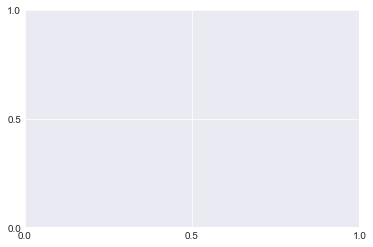

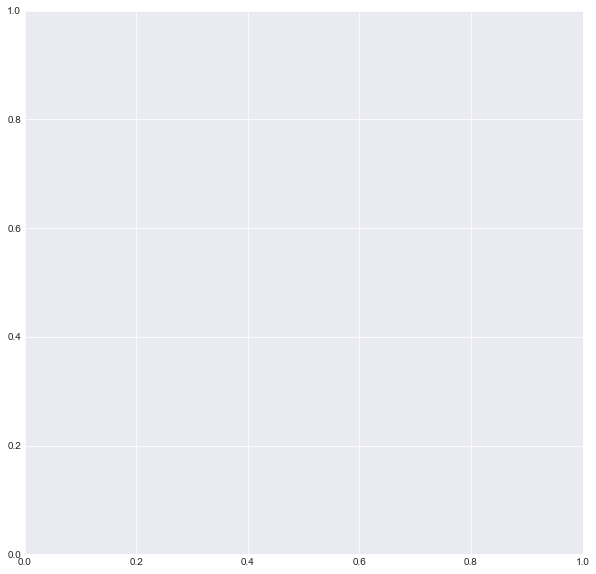

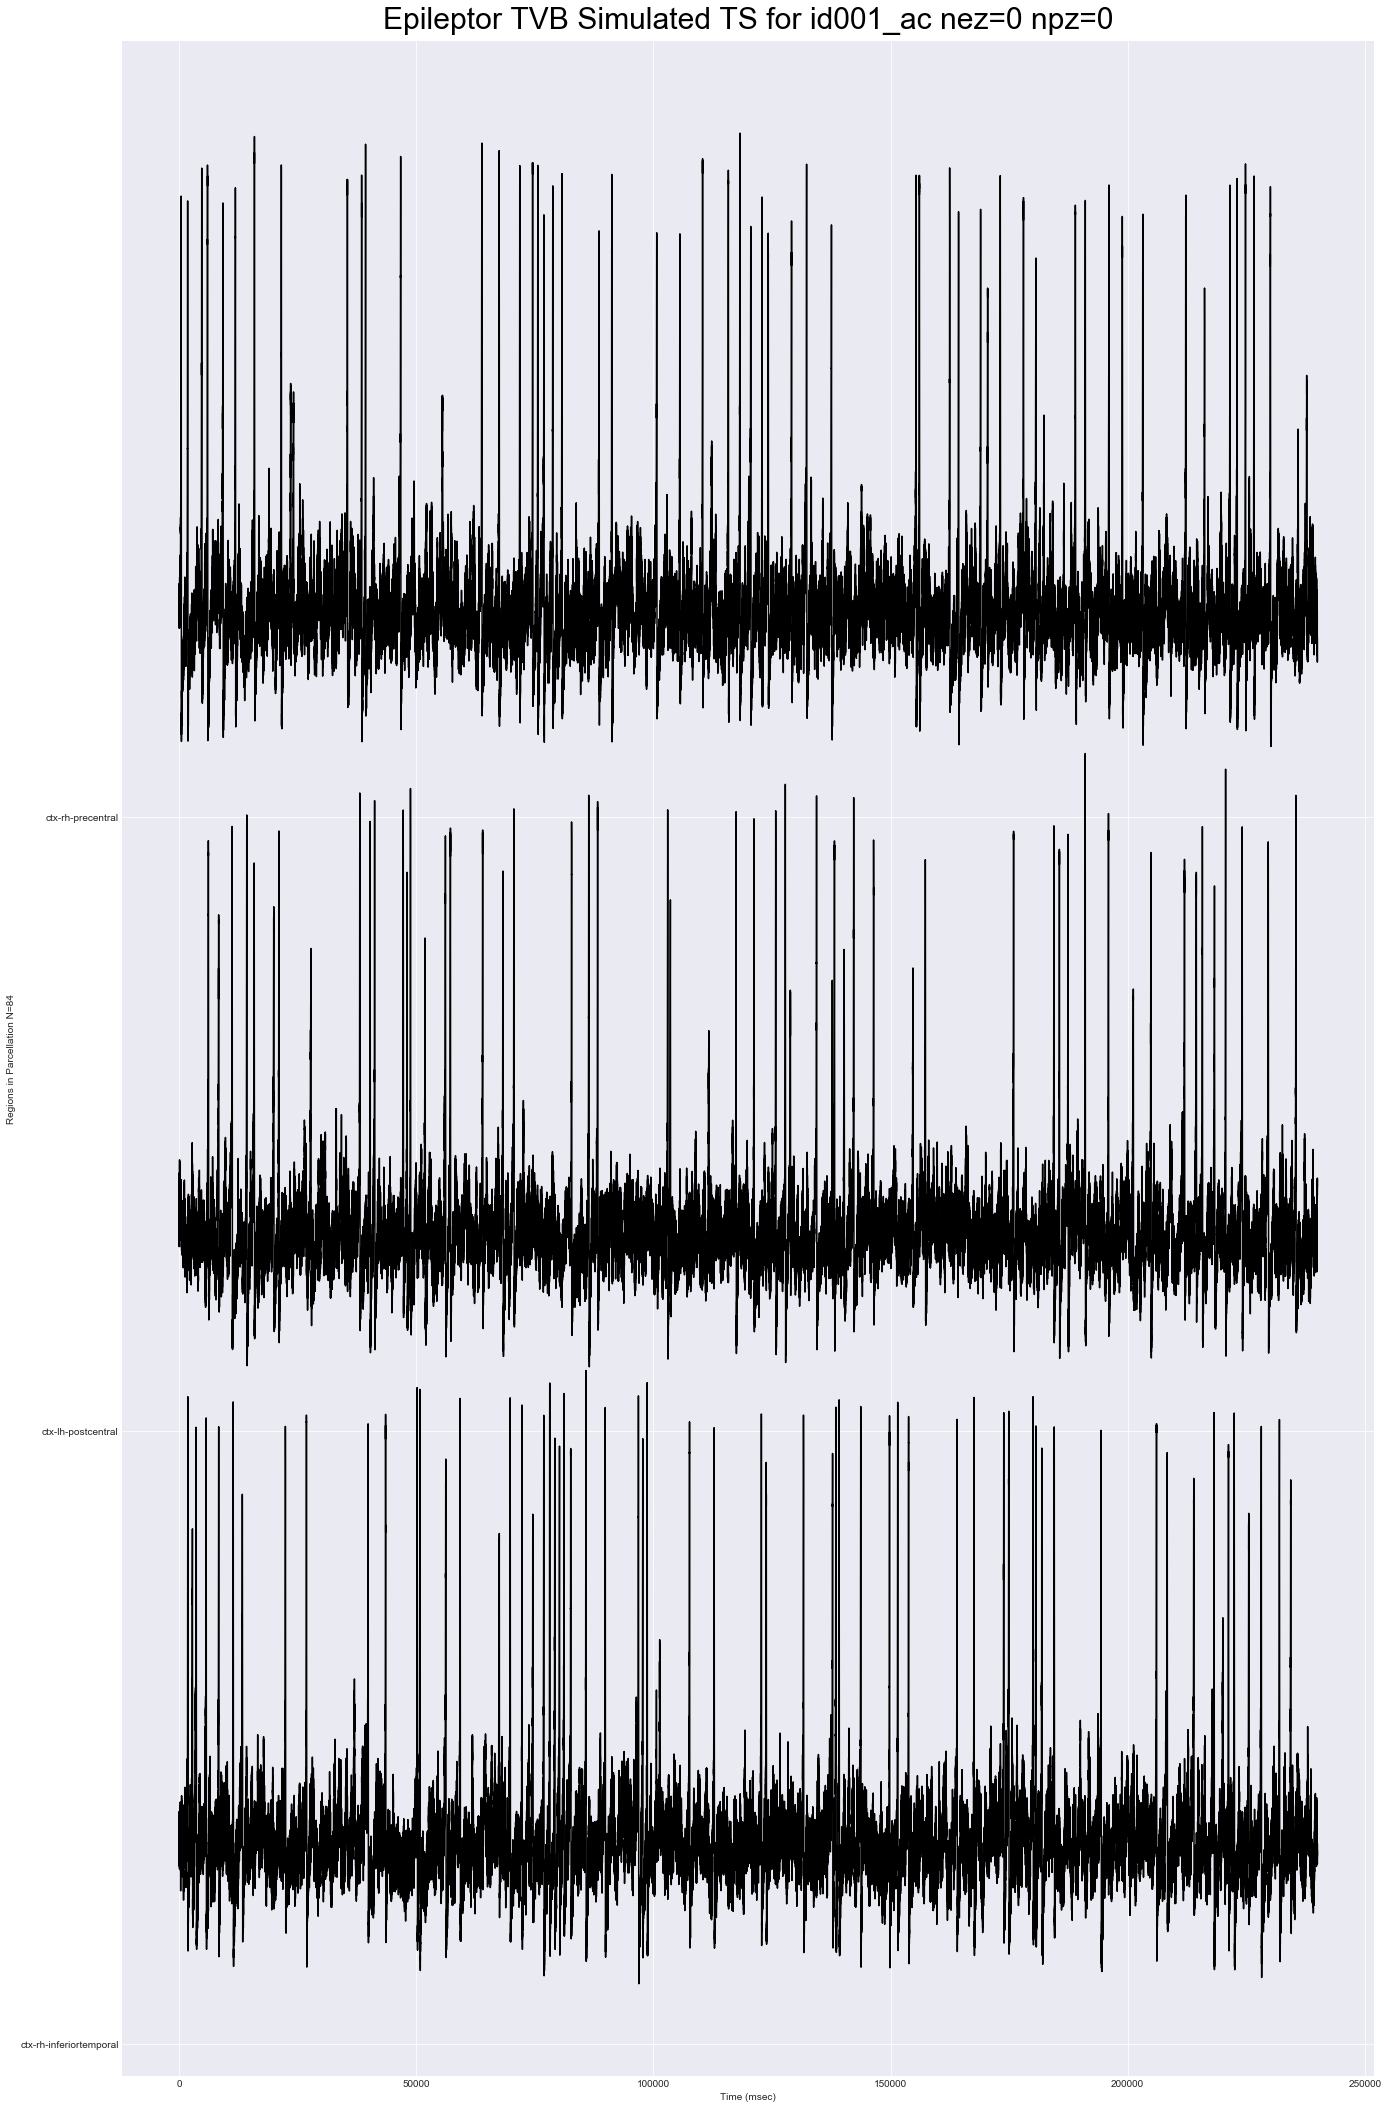

In [5]:
### Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'30', 'color':'black', 'weight':'normal',
          'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'family':'Arial', 'size':'30'}

color_new = ['peru', 'dodgerblue', 'slategrey', 
             'skyblue', 'springgreen', 'fuchsia', 'limegreen', 
             'orangered',  'gold', 'crimson', 'teal', 'blueviolet', 'black', 'cyan', 'lightseagreen',
             'lightpink', 'red', 'indigo', 'mediumorchid', 'mediumspringgreen']

rawplotter = tvbsim.visualize.RawPlotter(axis_font, title_font, color_new)
rawplotter.initializefig(figsize=(10,10))
for ezindex in ezindices:
    zfig = rawplotter.plotzts(zts[ezindex,:]-np.mean(zts[ezindex,:]), ezindex, list(onsettimes), list(offsettimes))
    
rawplotter.initializefig(figsize=(20,30))
epifig = rawplotter.plotepileptorts(epits, times, metadata, patient, onsettimes, offsettimes, plotsubset=True)

ez seeg index is:  []
here: [ 29.  60.  22.]
ezreion is:  []
pzregion is:  []
x0 values are (ez, pz, norm):  -1.6 -2.04 -2.5
time series shape is:  (70, 240000)
ez seeg index is:  []
chanstoplot are:  [29 60 22]


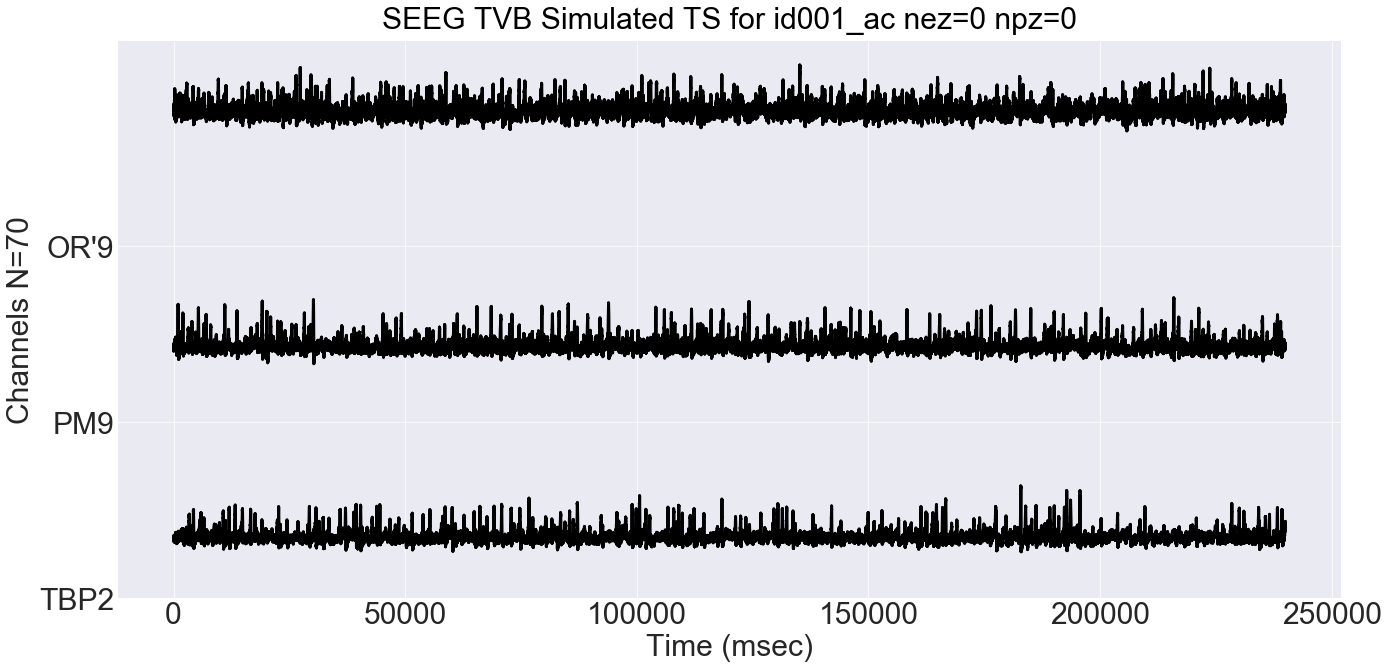

ez seeg index is:  []
here: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
ezreion is:  []
pzregion is:  []
x0 values are (ez, pz, norm):  -1.6 -2.04 -2.5
time series shape is:  (70, 240000)
ez seeg index is:  []
chanstoplot are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]


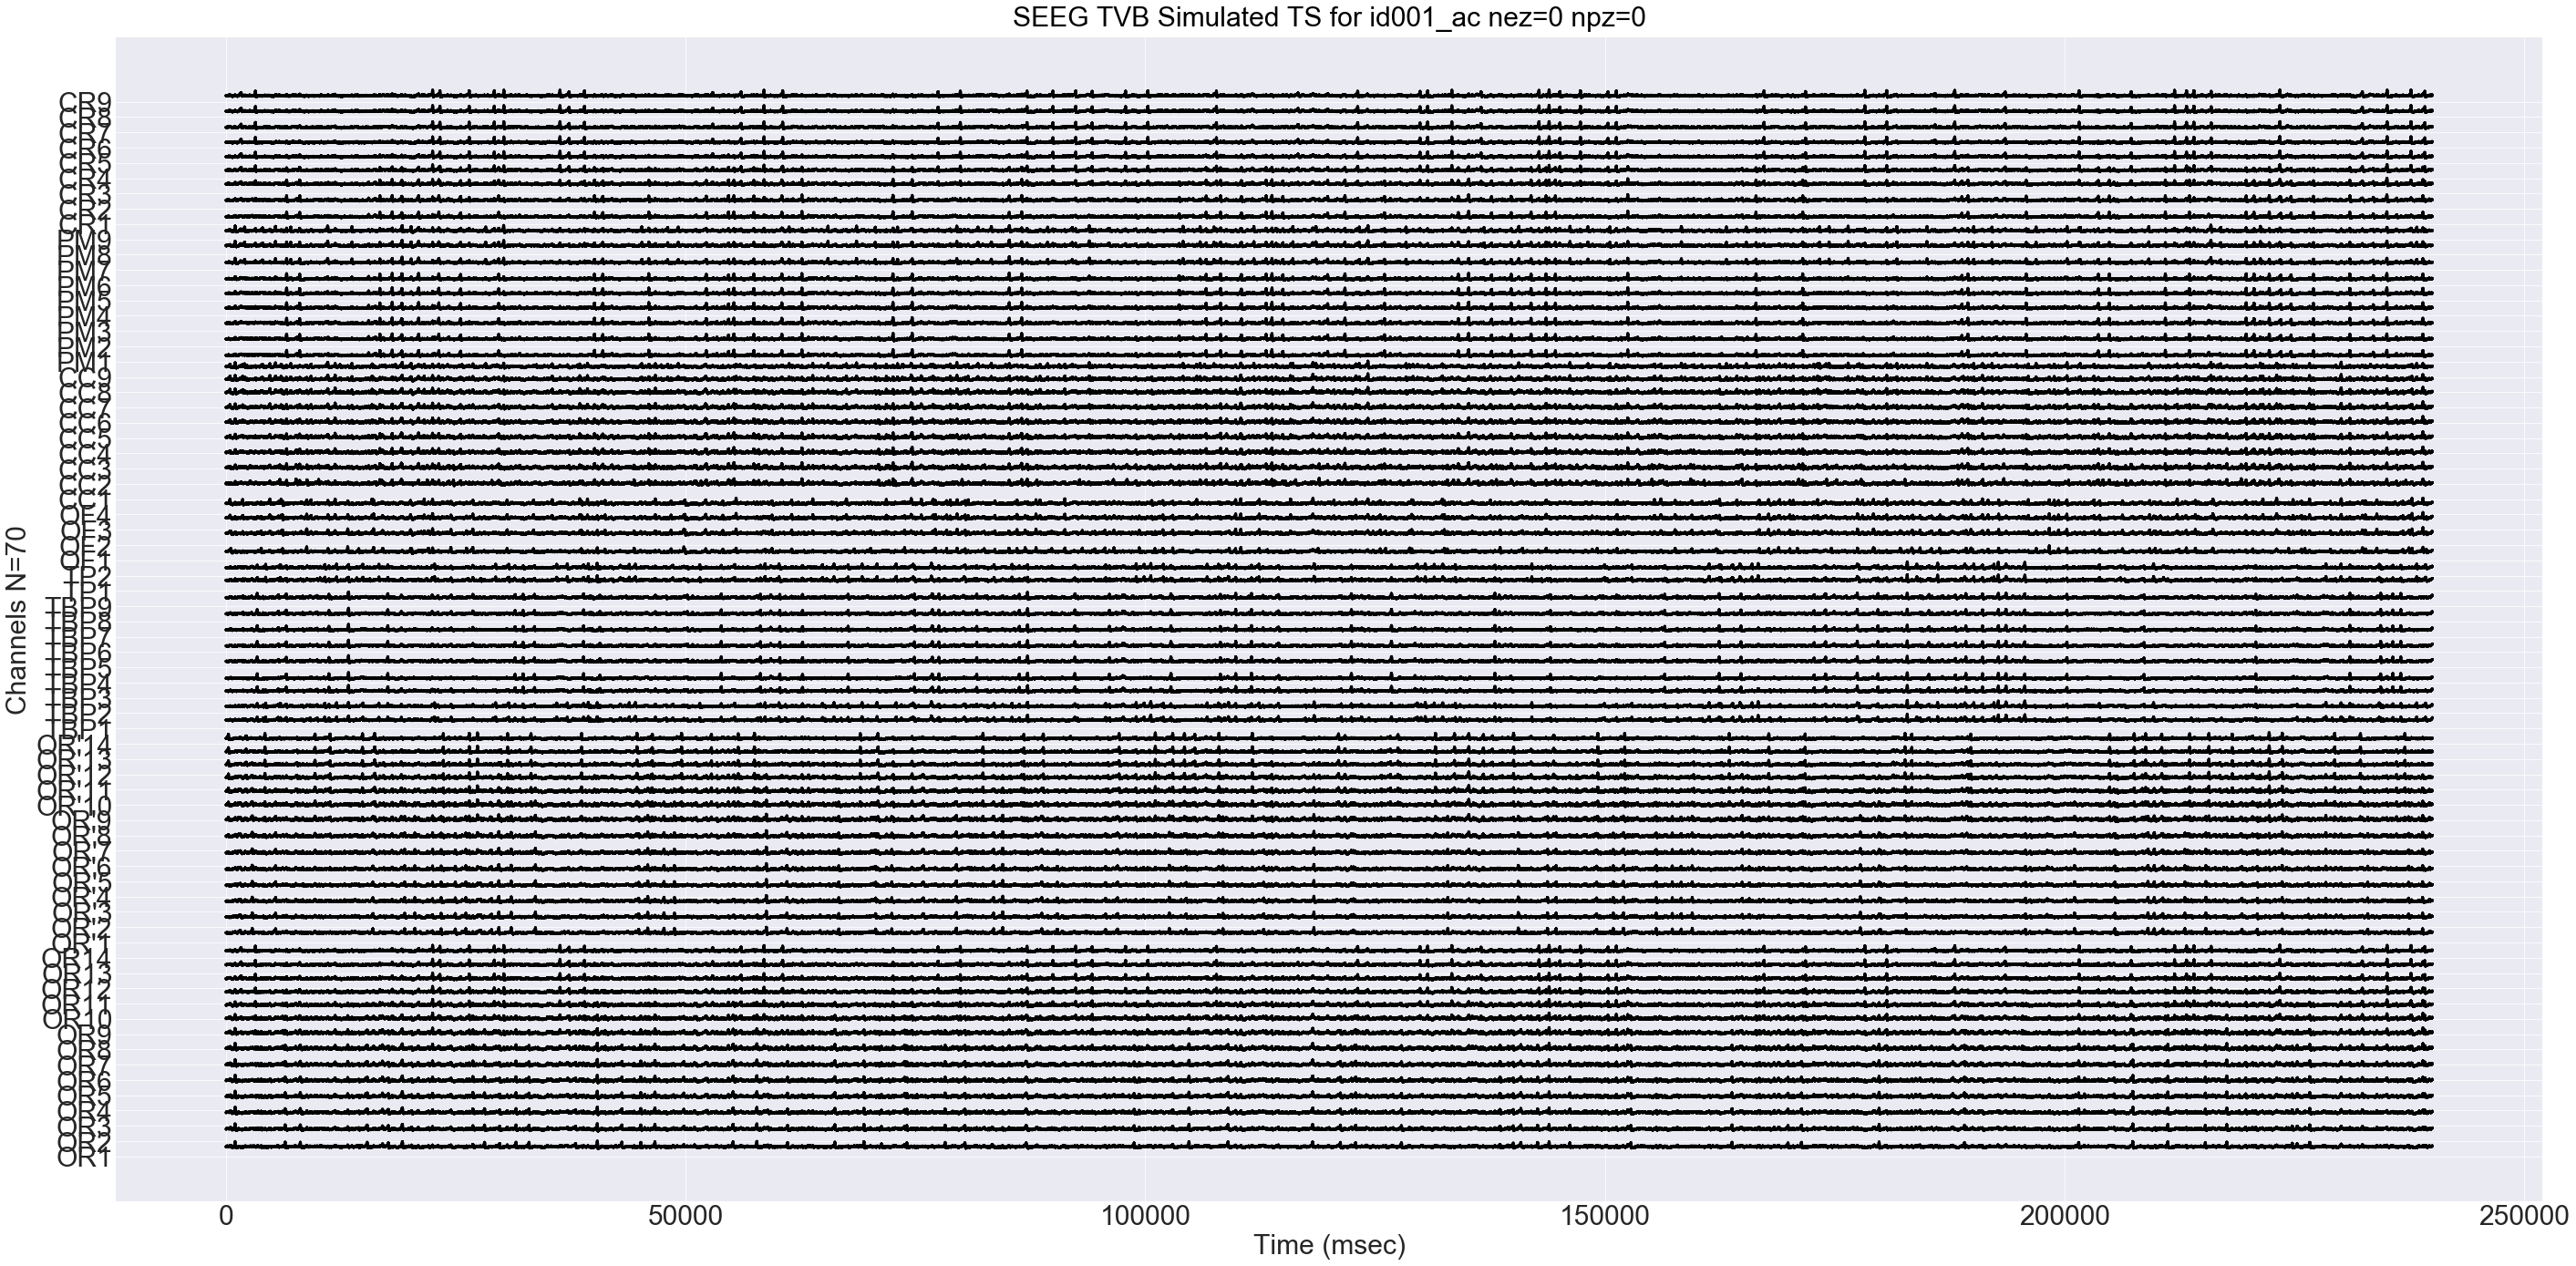

In [6]:
ezseegindex = []
rawplotter.initializefig(figsize=(20, 10))
seegfig = rawplotter.plotseegts(seegts, times, metadata, onsettimes, offsettimes, patient, ezseegindex, plotsubset=True)

rawplotter.initializefig(figsize=(40, 20))
seegfig = rawplotter.plotseegts(seegts, times, metadata, onsettimes, offsettimes, patient, ezseegindex, plotsubset=False)

num regions:  84
num contacts:  70
8
xreg:  (84,)
yreg:  (84,)
zreg:  (84,)
[]
[]


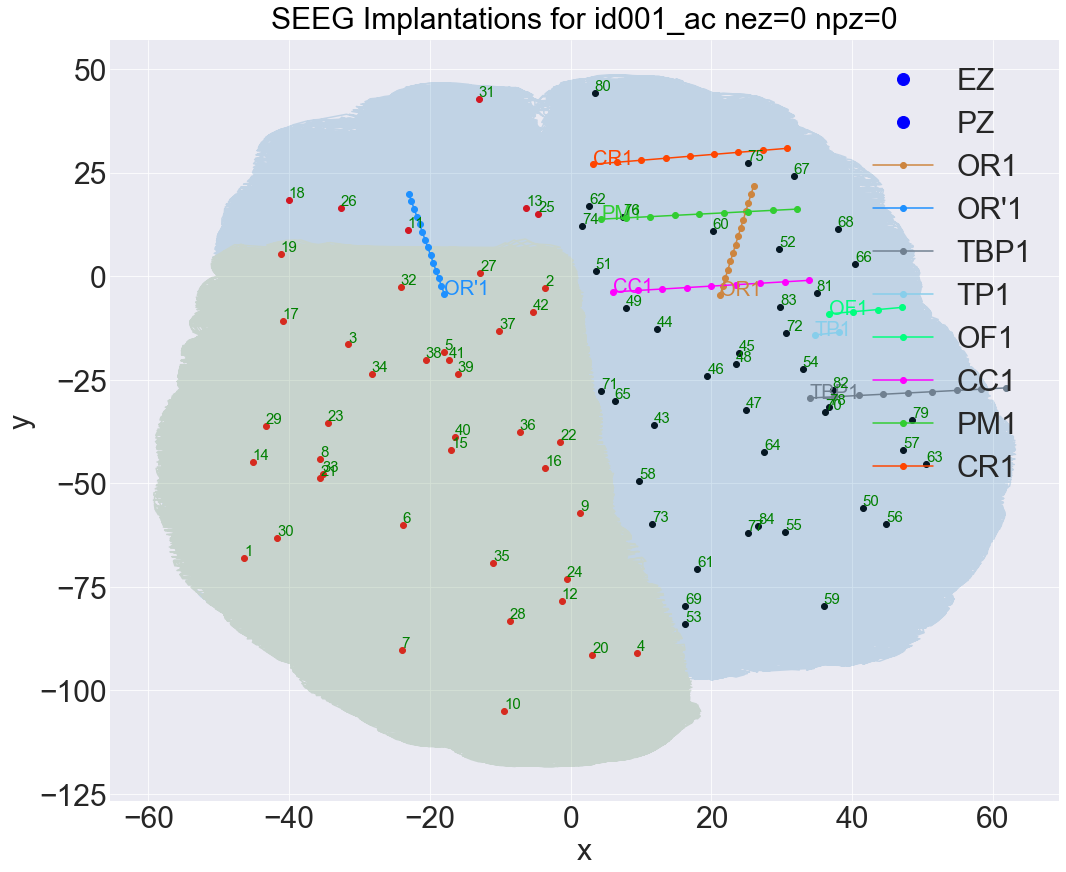

In [7]:
rawplotter.initializefig(figsize=(17,14))
rawplotter.plotcontactsinbrain(cort_surf, region_centers, region_labels, seeg_xyz, seeg_labels, incr_cont, patient, ezindices, pzindices=[])